In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import numpy.linalg as LA
import re
import nltk
from nltk.stem.porter import PorterStemmer

In [2]:
import json
from datetime import datetime as dt, date
import collections
import pandas as pd

In [225]:
from sklearn.metrics.pairwise import linear_kernel

In [165]:
sourcefnames = {'bloomberg' : 'data/scrapedbloomberg.json',
                'breitbart' : 'data/scrapedbreitbart.json',
                'cnn' : 'data/scrapedcnn.json',
                'fox' : 'data/scrapedfox.json',
                'guardian' : 'data/scrapedguardian.json',
                #'natl review' : 'data/scrapednatreview.json',
                'WaPo' : 'data/scrapedwapo.json'
               }

In [178]:
urls = {}
datecounts = {}
articles = {}
month_counts = {}

for k, v in sourcefnames.items():
    urls[k] = set()
    datecounts[k] = {}
    with open(v) as f:
        for line in f:
            art = json.loads(line)
            max_articles = False
            if art['date'] and art['sourceurl'] not in urls[k]:
                dobj = dt.strptime(art['date'][0:10], '%Y-%m-%d')
                art_length = (len(art['response_body']))
                if ((dobj.year == 2017 and dobj.month in (1,2)) or (dobj.year == 2016 and dobj.month == 12) and art_length > 2000 and art_length < 10000):
                    #print(len(art['response_body']))
                    if dobj in datecounts[k]:
                        if datecounts[k][dobj] <5:
                            datecounts[k][dobj] += 1
                        else:
                            max_articles = True
                    else:
                        datecounts[k][dobj] = 1
                    if not max_articles:
                        urls[k].add(art['sourceurl'])
                        if (dobj.month,k) in articles:
                            articles[(dobj.month,k)].append(art['response_body'])
                            month_counts[(dobj.month,k)]+=1
                        else:
                            articles[(dobj.month,k)]=list()
                            articles[(dobj.month,k)].append(art['response_body'])
                            month_counts[(dobj.month,k)]=1
                            
                    

In [190]:
month_counts

{(1, 'WaPo'): 32,
 (1, 'bloomberg'): 129,
 (1, 'breitbart'): 42,
 (1, 'cnn'): 121,
 (1, 'fox'): 71,
 (1, 'guardian'): 107,
 (2, 'WaPo'): 53,
 (2, 'bloomberg'): 99,
 (2, 'breitbart'): 80,
 (2, 'cnn'): 106,
 (2, 'fox'): 131,
 (2, 'guardian'): 44,
 (12, 'WaPo'): 16,
 (12, 'bloomberg'): 100,
 (12, 'breitbart'): 26,
 (12, 'cnn'): 29,
 (12, 'fox'): 41,
 (12, 'guardian'): 57}

In [191]:
#datecounts

In [192]:
names = [k for k,v in sourcefnames.items()]

In [242]:
def getArticleSubset(month, article_text):
    d_all = [article_text[t] for t in article_text if t[0] == month]
    d = [doc[1::round(len(doc)/15)] for doc in d_all]
#     for t in d:
#         print(len(t))
    d = [''.join(x) for x in d]
#     for t in d:
#         print(len(t))
    return d

In [220]:
names

['bloomberg', 'breitbart', 'cnn', 'fox', 'guardian', 'WaPo']

In [223]:
stopWords = stopwords.words('english')
#stopWords.extend(("sign","newsletter"))
porter_stemmer = PorterStemmer()
stop_stemmed = [porter_stemmer.stem(s) for s in stopWords]
tokenize = lambda doc: list(filter(None,re.split(r"\W|\d",doc.lower())))
def tokenize_stem(doc):
    tokens = re.split(r"\W|\d",doc)
    stemmed_tokens = [porter_stemmer.stem(t) for t in tokens if len(porter_stemmer.stem(t))>1]
    return list(filter(None,stemmed_tokens))

In [48]:
def cosine_similarities_mat(m):
    n = m.shape[0]
    cs_array = np.zeros((n,n))
    for i in range(n):
        cs_array[i]=(linear_kernel(m[i:i+1], m).flatten())
    return cs_array

In [49]:
def pearson_corr_mat(m):
    n = m.shape[0]
    pc_array_all = np.corrcoef(m.toarray(), m.toarray())
    pc_array = np.zeros((n,n))
    for i in range(n):
        pc_array[i]=pc_array_all[i][0:n]
    return pc_array

In [293]:
def getMostFreqTerms(n,d):
    d_tokenized =[tokenize_stem(doc) for doc in d]
    d_no_stop =[[w for w in d if w not in stop_stemmed] for d in d_tokenized]
    d_Freq =[FreqDist(doc) for doc in d_no_stop]
    d_common_n =[f.most_common(n) for f in d_Freq]
    d_most_common_words = [list(zip(*d))[0] for d in d_common_n]
    return d_most_common_words

In [302]:
def jaccard_similarity(d1, d2):
    intersection = set(d1).intersection(set(d2))
    union = set(d1).union(set(d2))
    return len(intersection)/len(union)

In [303]:
def jaccard_similarity_mat(m):
    n = len(m)
    array = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            sim = jaccard_similarity(m[i],m[j])
            array[i][j] = sim
            array[j][i] = sim
    return array

In [363]:
def getDistancebyTime(months,articles,distance_measure = 'C',sublinear=True,ngram_range = (1,1),max_terms = None,js_most_freq = 50):
    dfs = []
    for m in months:
        d = getArticleSubset(m,articles)
        tfidf_vec = TfidfVectorizer(stop_words = stop_stemmed,tokenizer=tokenize_stem,sublinear_tf=sublinear,ngram_range=(1,1),max_features=max_terms)
        tfidf = tfidf_vec.fit_transform(d)
        if distance_measure == 'C':
            distance_mat = cosine_similarities_mat(tfidf)
        elif distance_measure == 'P':
            distance_mat = pearson_corr_mat(tfidf) 
        elif distance_measure == 'J':
            freq_terms = getMostFreqTerms(js_most_freq,d)
            distance_mat = jaccard_similarity_mat(freq_terms)
        df = pd.DataFrame(distance_mat,index = names,columns = names)
        dfs.append(df)
    return dfs

SyntaxError: invalid syntax (<ipython-input-363-69db52a1fca8>, line 17)

In [321]:
months = [12,1,2]
cs= getDistancebyTime(months,articles,sublinear=False,distance_measure='C')

In [322]:
#look at distance matrix for specific months (e.g. Dec=0)
cs[0]

,bloomberg,breitbart,cnn,fox,guardian,WaPo
bloomberg,1.000000,0.340292,0.550078,0.518221,0.492328,0.521149
breitbart,0.340292,1.000000,0.380073,0.395800,0.369892,0.362280
cnn,0.550078,0.380073,1.000000,0.584821,0.614435,0.766413
fox,0.518221,0.395800,0.584821,1.000000,0.518333,0.593294
guardian,0.492328,0.369892,0.614435,0.518333,1.000000,0.634701
WaPo,0.521149,0.362280,0.766413,0.593294,0.634701,1.000000


In [323]:
cs[1]

,bloomberg,breitbart,cnn,fox,guardian,WaPo
bloomberg,1.000000,0.440700,0.653540,0.618204,0.550312,0.637483
breitbart,0.440700,1.000000,0.501656,0.505754,0.503854,0.494652
cnn,0.653540,0.501656,1.000000,0.705739,0.670499,0.758422
fox,0.618204,0.505754,0.705739,1.000000,0.639664,0.704908
guardian,0.550312,0.503854,0.670499,0.639664,1.000000,0.691629
WaPo,0.637483,0.494652,0.758422,0.704908,0.691629,1.000000


In [324]:
cs[2]

,bloomberg,breitbart,cnn,fox,guardian,WaPo
bloomberg,1.000000,0.450372,0.463395,0.454358,0.468434,0.505854
breitbart,0.450372,1.000000,0.542902,0.512624,0.487690,0.523634
cnn,0.463395,0.542902,1.000000,0.569048,0.631362,0.636983
fox,0.454358,0.512624,0.569048,1.000000,0.534134,0.605160
guardian,0.468434,0.487690,0.631362,0.534134,1.000000,0.572931
WaPo,0.505854,0.523634,0.636983,0.605160,0.572931,1.000000


In [325]:
#compare months (eg dec(0) and jan(1))
round(cs[0]-cs[1],2)

,bloomberg,breitbart,cnn,fox,guardian,WaPo
bloomberg,0.00,-0.10,-0.10,-0.10,-0.06,-0.12
breitbart,-0.10,-0.00,-0.12,-0.11,-0.13,-0.13
cnn,-0.10,-0.12,0.00,-0.12,-0.06,0.01
fox,-0.10,-0.11,-0.12,-0.00,-0.12,-0.11
guardian,-0.06,-0.13,-0.06,-0.12,-0.00,-0.06
WaPo,-0.12,-0.13,0.01,-0.11,-0.06,0.00


In [326]:
#Pearson Distance Measures
pc = getDistancebyTime(months,articles,distance_measure='P',sublinear=False)

In [327]:
pc[0]

,bloomberg,breitbart,cnn,fox,guardian,WaPo
bloomberg,1.000000,0.265284,0.498590,0.457335,0.414940,0.469849
breitbart,0.265284,1.000000,0.313997,0.325045,0.280725,0.298341
cnn,0.498590,0.313997,1.000000,0.535965,0.561775,0.742926
fox,0.457335,0.325045,0.535965,1.000000,0.442240,0.548714
guardian,0.414940,0.280725,0.561775,0.442240,1.000000,0.589670
WaPo,0.469849,0.298341,0.742926,0.548714,0.589670,1.000000


In [328]:
pc[1]

,bloomberg,breitbart,cnn,fox,guardian,WaPo
bloomberg,1.000000,0.360665,0.611423,0.564499,0.484200,0.594351
breitbart,0.360665,1.000000,0.442688,0.439253,0.434273,0.436035
cnn,0.611423,0.442688,1.000000,0.671696,0.631091,0.733707
fox,0.564499,0.439253,0.671696,1.000000,0.589942,0.671541
guardian,0.484200,0.434273,0.631091,0.589942,1.000000,0.655722
WaPo,0.594351,0.436035,0.733707,0.671541,0.655722,1.000000


In [329]:
pc[2]

,bloomberg,breitbart,cnn,fox,guardian,WaPo
bloomberg,1.000000,0.373836,0.400441,0.383219,0.385192,0.450903
breitbart,0.373836,1.000000,0.487225,0.446168,0.403204,0.468666
cnn,0.400441,0.487225,1.000000,0.519496,0.582950,0.600774
fox,0.383219,0.446168,0.519496,1.000000,0.463128,0.562202
guardian,0.385192,0.403204,0.582950,0.463128,1.000000,0.519595
WaPo,0.450903,0.468666,0.600774,0.562202,0.519595,1.000000


In [330]:
js = getDistancebyTime(months,articles,distance_measure='J',js_most_freq=100)

In [331]:
js[0]

,bloomberg,breitbart,cnn,fox,guardian,WaPo
bloomberg,1.000000,0.190476,0.219512,0.234568,0.219512,0.257862
breitbart,0.190476,1.000000,0.176471,0.226994,0.234568,0.219512
cnn,0.219512,0.176471,1.000000,0.273885,0.298701,0.398601
fox,0.234568,0.226994,0.273885,1.000000,0.242236,0.273885
guardian,0.219512,0.234568,0.298701,0.242236,1.000000,0.282051
WaPo,0.257862,0.219512,0.398601,0.273885,0.282051,1.000000


In [332]:
js[1]

,bloomberg,breitbart,cnn,fox,guardian,WaPo
bloomberg,1.000000,0.234568,0.369863,0.333333,0.242236,0.342282
breitbart,0.234568,1.000000,0.250000,0.273885,0.197605,0.242236
cnn,0.369863,0.250000,1.000000,0.438849,0.324503,0.418440
fox,0.333333,0.273885,0.438849,1.000000,0.315789,0.388889
guardian,0.242236,0.197605,0.324503,0.315789,1.000000,0.333333
WaPo,0.342282,0.242236,0.418440,0.388889,0.333333,1.000000


In [333]:
js[2]

,bloomberg,breitbart,cnn,fox,guardian,WaPo
bloomberg,1.000000,0.242236,0.183432,0.183432,0.242236,0.183432
breitbart,0.242236,1.000000,0.298701,0.324503,0.351351,0.282051
cnn,0.183432,0.298701,1.000000,0.307190,0.315789,0.307190
fox,0.183432,0.324503,0.307190,1.000000,0.315789,0.315789
guardian,0.242236,0.351351,0.315789,0.315789,1.000000,0.273885
WaPo,0.183432,0.282051,0.307190,0.315789,0.273885,1.000000


In [1134]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [368]:
def getTermFreqbyTime(months,articles,ngram_range = (1,1),max_terms = 10):
    dfs = []
    for m in months:
        d = getArticleSubset(m,articles)
        tfidf_vec = TfidfVectorizer(stop_words = stop_stemmed,tokenizer=tokenize_stem,ngram_range=(1,1),max_features=max_terms)
        tfidf = tfidf_vec.fit_transform(d)
        features = tfidf_vec.get_feature_names()
        dfs.append(pd.DataFrame(np.transpose(tfidf.toarray()), index = features, columns = names))
    return dfs

In [369]:
most = getTermFreqbyTime(months,articles,max_terms = 20)

In [370]:
def plot_mf_hist(df):
    plt.rcParams['figure.figsize'] = (10, 15)
    ind = np.arange(len(df))
    width = 0.15
    colors = ["red", "blue", "green", "yellow","black", "purple"]
    fig, ax = plt.subplots()
    for i in range(len(df.columns)-1):
        col_name = df.columns[i]
        ax.barh(ind + width*(i-1), df[col_name], width, color=colors[i], label=col_name)

    ax.set(yticks=ind + width, yticklabels=df.index, ylim=[2*width - 1, len(df)])
    ax.legend()
    plt.show()

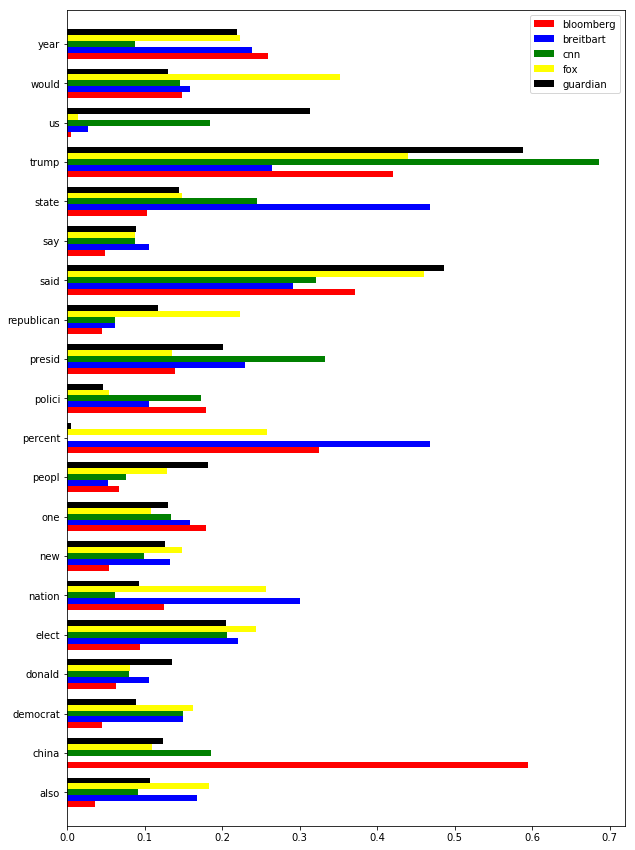

In [371]:
plot_mf_hist(most[0])

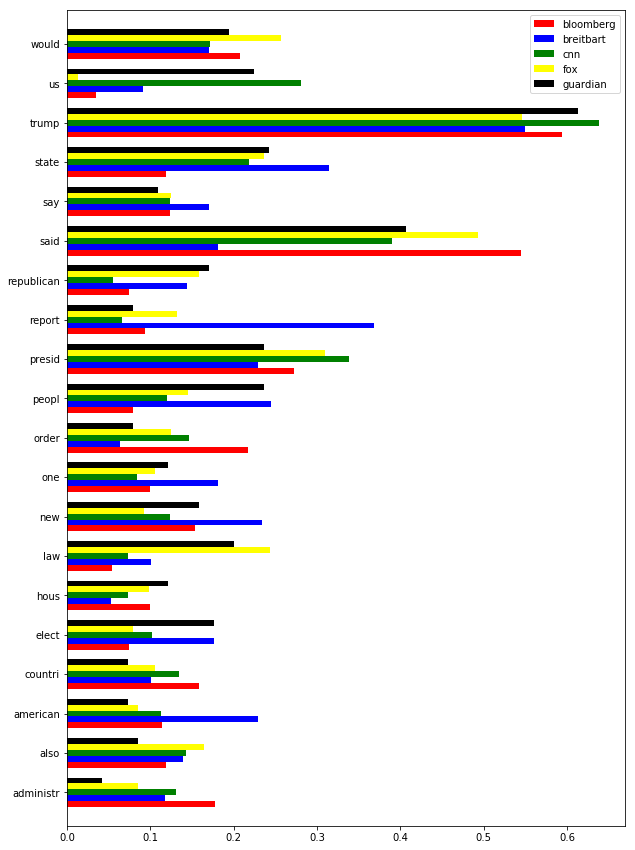

In [372]:
plot_mf_hist(most[1])

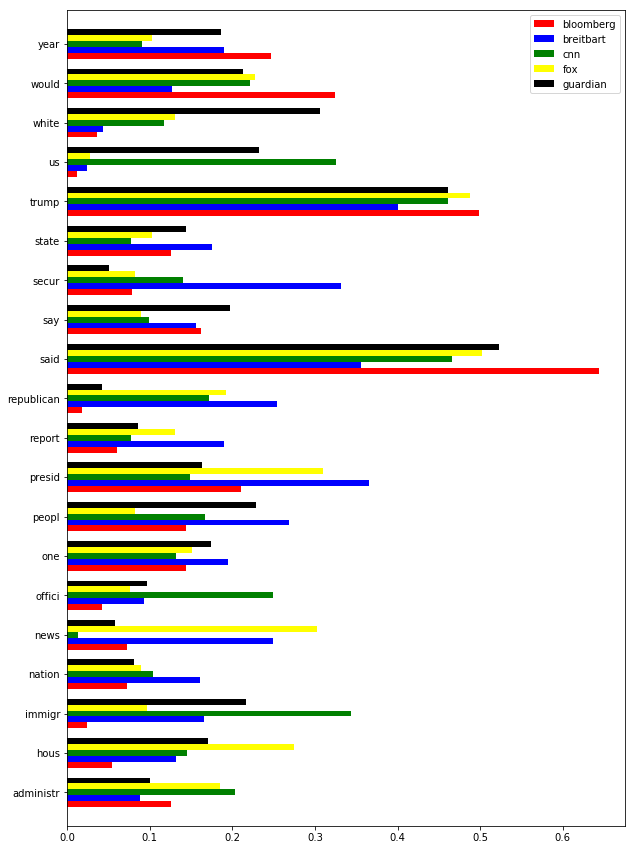

In [373]:
plot_mf_hist(most[2])

## Original

In [79]:
def read_text (file):
    with open(file,'r') as f:
        text = f.read()
    f.close()
    return text

In [80]:
bb = read_text('data/breitbart_pol_feb_20_26.txt')
nyt = read_text('data/nyt_pol_feb_20_26.txt')
hp = read_text('data/huffpost_pol_feb_20_26.txt')
fox = read_text('data/fox_pol_feb_20_26.txt')


In [81]:
d = [bb,nyt,fox,hp]
names = ["breitbart","nyt","fox","hp"]

In [82]:
stopWords = stopwords.words('english')
tokenize = lambda doc: list(filter(None,re.split(r"\W|\d",doc.lower())))


In [98]:
tfidf_vec = TfidfVectorizer(stop_words = stopWords,tokenizer=tokenize)
tfidf = tfidf_vec.fit_transform(d)
#print(td_mat.shape)
#count_vect.get_feature_names()

In [99]:
#tf and tf-idf
# tf_transformer = TfidfTransformer(use_idf=False)
# tf = tf_transformer.fit_transform(td_mat)
# tfidf_transformer = TfidfTransformer()
# tfidf = tfidf_transformer.fit_transform(td_mat)

In [100]:
from sklearn.metrics.pairwise import linear_kernel

In [12]:
count_vect = CountVectorizer(max_features = 50,stop_words = stopWords,tokenizer=tokenize)
td_mat = count_vect.fit_transform(d)
#count_vect.get_feature_names()
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(td_mat)

In [729]:
d_most_common_words = [list(zip(*d))[0] for d in d_common_50]